## Задача - предсказать шансы студентов быть трудоустроенными после кампус отбора.

по фичам таким как - громкость, темп, тональность, акустичность, энергичность и т.п


### Шаг 1. Подготовка данных к машинному обучению.

#### 1. Импорт библиотек
#### 2. Импорт данных
#### 3. Краткий анализ данных
#### 4. Разделение данных для машинного обучения
#### 5. Энкодинг и скейлинг данных
#### 6. Применение метода SMOTE для балансировки лейбла.
#### 7. Кросс валидация

#### 1. Импорт библиотек

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import optuna

#### 2. Загрузка данных

In [37]:
df = pd.read_csv('Campus_Selection.csv')

#### 3. Краткий анализ данных

In [38]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
dtypes: float64(5), int64(1), object(8)
memory usage: 23.6+ KB


#### Пропущенные данные отсутствуют

In [40]:
df.describe()

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,108.000000,67.303395,66.333163,66.370186,72.100558,62.278186
std,62.209324,10.827205,10.897509,7.358743,13.275956,5.833385
min,1.000000,40.890000,37.000000,50.000000,50.000000,51.210000
25%,54.500000,60.600000,60.900000,61.000000,60.000000,57.945000
50%,108.000000,67.000000,65.000000,66.000000,71.000000,62.000000
75%,161.500000,75.700000,73.000000,72.000000,83.500000,66.255000
max,215.000000,89.400000,97.700000,91.000000,98.000000,77.890000


In [41]:
df['status'].value_counts()

status
Placed        148
Not Placed     67
Name: count, dtype: int64

#### Лейбл класс несбалансирован, нужно применить технику SMOTE

In [ ]:
df['ssc_p'].plot(kind = 'bar')
plt.show()

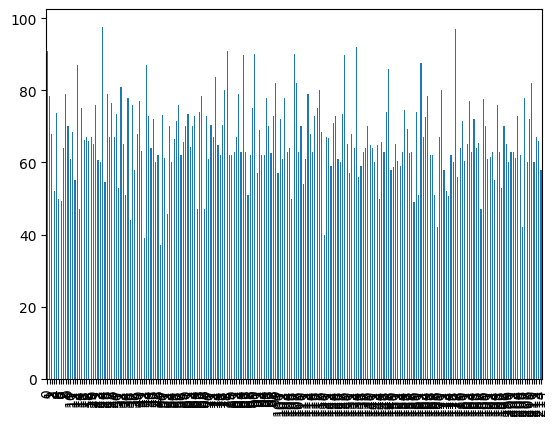

In [11]:
df['hsc_p'].plot(kind = 'bar')
plt.show()

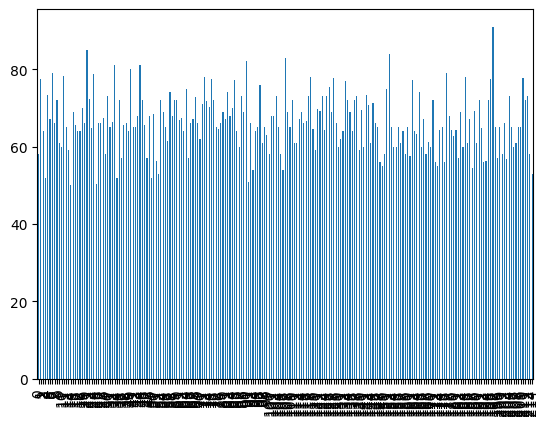

In [12]:
df['degree_p'].plot(kind = 'bar')
plt.show()

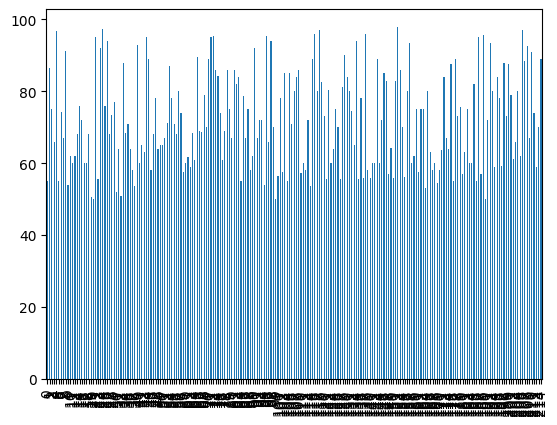

In [13]:
df['etest_p'].plot(kind = 'bar')
plt.show()

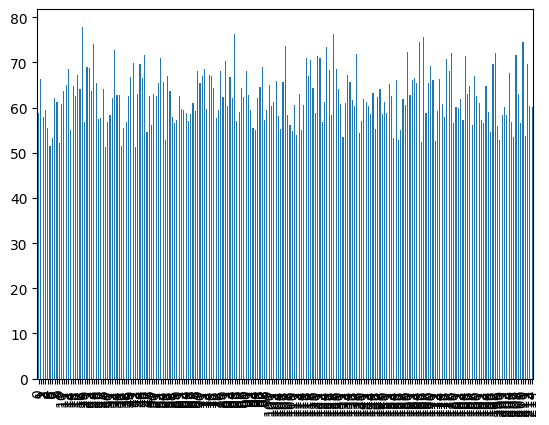

In [14]:
df['mba_p'].plot(kind = 'bar')
plt.show()

#### 3. Результат анализа данных:

- Необходимо удалить фичу sl_no, энкодировать лейбл и фичи такие как - gender, ssc_b, hsc_b, hsc_s, degree_t, workex, specialisation.
- В силу того что лейбл несбалансирован, необходимо применить технику SMOTE.
- Графический анализ numerical фичей показал что ко всем нужно применять MinMaxScaler, т.к все фичи не следуют нормальному распределению.

#### 4. Разделение данных для машинного обучения

In [42]:
df.drop(['sl_no'], axis = 1 ,inplace = True)

In [43]:
df.columns

Index(['gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', 'hsc_s', 'degree_p',
       'degree_t', 'workex', 'etest_p', 'specialisation', 'mba_p', 'status'],
      dtype='object')

In [44]:
X = df.drop(['status'], axis = 1)
y = df['status']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### 5. Энкодинг и скейлинг данных

In [46]:
processor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation'])
    ]
)

In [47]:
X_train_encoded = processor.fit_transform(X_train)
X_test_encoded = processor.transform(X_test)

In [48]:
label = LabelEncoder()
y_train_encoded = label.fit_transform(y_train)
y_test_encoded = label.transform(y_test)

#### 5. Применение SMOTE для балансировки данных.

In [49]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train_encoded)

#### 7. Кросс валидация

In [50]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(solver='liblinear', max_iter=200)
scores = cross_val_score(model, X_train_smote, y_train_smote, cv=kfold)

print("--- Результаты кросс-валидации ---")
print(f"Оценки по каждому фолду: {scores}")
print(f"Средняя точность кросс-валидации: {scores.mean():.4f}")
print(f"Стандартное отклонение оценок: {scores.std():.4f}")

--- Результаты кросс-валидации ---
Оценки по каждому фолду: [0.79166667 0.78723404 0.82978723 0.85106383 0.82978723]
Средняя точность кросс-валидации: 0.8179
Стандартное отклонение оценок: 0.0245


### Шаг 2. Применение алгоритмов машинного обучения

#### 1. Логичтическая регрессия как baseline для дальнейшей оценки перформанса других моделей.
#### 2. Hyperparameter tuning и поиск оптимальных параметров для алгоритмов - "LogisticRegression"(Ridge, lasso), "kNN", "SVM", "DecisionTree", "RandomForest".
#### 3. Запуск алгоритмов с лучшими параметрами найденными через hyperparameter tuning.
#### 4. Анализ метрик Accuracy, Precision, Recall, F1, RPC-AUC.
#### 5. Выводы

#### 1. Логичтическая регрессия как baseline для дальнейшей оценки перформанса других моделей.

In [51]:
model = LogisticRegression(solver='liblinear', max_iter=200)
model.fit(X_train_smote, y_train_smote)

# Делаем предсказания
y_train_pred = model.predict(X_train_encoded)
y_test_pred = model.predict(X_test_encoded)

# Оцениваем точность
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("--- Результаты оценки ---")
print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

--- Результаты оценки ---
Точность на обучающей выборке: 0.8663
Точность на тестовой выборке: 0.8605


#### Так как Accuracy одинаковый, переобучение отсутствует.

#### 2. Hyperparameter tuning и поиск оптимальных параметров для алгоритмов - "LogisticRegression"(Ridge, lasso), "kNN", "SVM", "DecisionTree", "RandomForest".

In [52]:
def objective(trial, model_name):
    """
    The core function that Optuna will optimize.
    It suggests hyperparameters, creates a model, and returns its cross-validated accuracy.
    """

    if model_name == "LogisticRegression":
        params = {
            'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
            'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2'])
        }
        if params['solver'] == 'liblinear' and params['penalty'] == 'l1':
            pass
        elif params['solver'] == 'saga':
            pass
        else:
            params['penalty'] = 'l2'

        model = LogisticRegression(**params)

    elif model_name == "kNN":
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 3, 50),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            'p': trial.suggest_int('p', 1, 2) # 1 for Manhattan, 2 for Euclidean
        }
        model = KNeighborsClassifier(**params)

    elif model_name == "SVM":
        params = {
            'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        }
        if params['kernel'] == 'rbf' or params['kernel'] == 'poly':
            params['gamma'] = trial.suggest_float('gamma', 1e-4, 1e2, log=True)
        if params['kernel'] == 'poly':
            params['degree'] = trial.suggest_int('degree', 2, 5)

        model = SVC(**params, probability=True)

    elif model_name == "DecisionTree":
        params = {
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'max_depth': trial.suggest_int('max_depth', 2, 32),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }
        model = DecisionTreeClassifier(**params, random_state=42)

    elif model_name == "RandomForest":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
        }
        model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)

    else:
        raise ValueError(f"Model {model_name} is not supported.")

    accuracy = cross_val_score(model, X_train_smote, y_train_smote, n_jobs=-1, cv=5, scoring='accuracy').mean()

    return accuracy

In [55]:
models_to_tune = ["LogisticRegression", "kNN", "SVM", "DecisionTree", "RandomForest"]

best_models = {}

for model_name in models_to_tune:
  print(f"🚀 Starting optimization for: {model_name}")

  study = optuna.create_study(direction='maximize')
  study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

  print(f"Optimization finished for: {model_name}")
  print(f"Best trial accuracy: {study.best_value:.4f}")
  print(f"Best parameters: {study.best_params}")
  print("-" * 50)

  best_models[model_name] = study.best_params

  print("\nHere are the best hyperparameters found for each model:")
  for model_name, params in best_models.items():
    print(f"\nModel: {model_name}")
    print(f"  Parameters: {params}")

[I 2025-09-21 16:11:36,720] A new study created in memory with name: no-name-00003fa9-985d-4600-b621-5f09ff24b996


🚀 Starting optimization for: LogisticRegression


[I 2025-09-21 16:11:37,823] Trial 0 finished with value: 0.4957446808510638 and parameters: {'C': 0.00023366020835523225, 'solver': 'saga', 'penalty': 'l1'}. Best is trial 0 with value: 0.4957446808510638.
[I 2025-09-21 16:11:38,612] Trial 1 finished with value: 0.8812056737588652 and parameters: {'C': 17.890224690739743, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.8812056737588652.
[I 2025-09-21 16:11:39,441] Trial 2 finished with value: 0.7716312056737589 and parameters: {'C': 0.10443266199321084, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.8812056737588652.
[I 2025-09-21 16:11:40,156] Trial 3 finished with value: 0.4999999999999999 and parameters: {'C': 0.012562564393626822, 'solver': 'liblinear', 'penalty': 'l1'}. Best is trial 1 with value: 0.8812056737588652.
[I 2025-09-21 16:11:40,169] Trial 4 finished with value: 0.6784574468085107 and parameters: {'C': 0.0005406523751030284, 'solver': 'liblinear', 'penalty': 'l2'}. Best is 

Optimization finished for: LogisticRegression
Best trial accuracy: 0.8896
Best parameters: {'C': 3471.264164719401, 'solver': 'saga', 'penalty': 'l1'}
--------------------------------------------------

Here are the best hyperparameters found for each model:

Model: LogisticRegression
  Parameters: {'C': 3471.264164719401, 'solver': 'saga', 'penalty': 'l1'}
🚀 Starting optimization for: kNN


[I 2025-09-21 16:11:41,007] Trial 4 finished with value: 0.7926418439716312 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 1}. Best is trial 4 with value: 0.7926418439716312.
[I 2025-09-21 16:11:41,020] Trial 5 finished with value: 0.7968971631205674 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'p': 1}. Best is trial 5 with value: 0.7968971631205674.
[I 2025-09-21 16:11:41,032] Trial 6 finished with value: 0.7842198581560283 and parameters: {'n_neighbors': 47, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.7968971631205674.
[I 2025-09-21 16:11:41,046] Trial 7 finished with value: 0.6914007092198581 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.7968971631205674.
[I 2025-09-21 16:11:41,057] Trial 8 finished with value: 0.7884751773049645 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.7968971631205674.
[I 2025-09-21 16:11:41,069] Trial 9 finis

Optimization finished for: kNN
Best trial accuracy: 0.8392
Best parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}
--------------------------------------------------

Here are the best hyperparameters found for each model:

Model: LogisticRegression
  Parameters: {'C': 3471.264164719401, 'solver': 'saga', 'penalty': 'l1'}

Model: kNN
  Parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}
🚀 Starting optimization for: SVM


[I 2025-09-21 16:11:41,853] Trial 15 finished with value: 0.8857269503546099 and parameters: {'C': 0.09120954569508201, 'kernel': 'poly', 'gamma': 1.437519979475687, 'degree': 2}. Best is trial 0 with value: 0.8984042553191489.
[I 2025-09-21 16:11:41,866] Trial 16 finished with value: 0.89822695035461 and parameters: {'C': 3707.278422580436, 'kernel': 'rbf', 'gamma': 0.01277804726747652}. Best is trial 0 with value: 0.8984042553191489.
[I 2025-09-21 16:11:41,890] Trial 17 finished with value: 0.6737588652482269 and parameters: {'C': 15.099285199968538, 'kernel': 'rbf', 'gamma': 86.44981577009014}. Best is trial 0 with value: 0.8984042553191489.
[I 2025-09-21 16:11:41,904] Trial 18 finished with value: 0.524822695035461 and parameters: {'C': 0.756211185163721, 'kernel': 'poly', 'gamma': 0.04150157773127019, 'degree': 4}. Best is trial 0 with value: 0.8984042553191489.
[I 2025-09-21 16:11:42,127] Trial 19 finished with value: 0.8896276595744681 and parameters: {'C': 641.149258641161, 'ke

Optimization finished for: SVM
Best trial accuracy: 0.9110
Best parameters: {'C': 1235.443738937326, 'kernel': 'rbf', 'gamma': 0.005875343108845897}
--------------------------------------------------

Here are the best hyperparameters found for each model:

Model: LogisticRegression
  Parameters: {'C': 3471.264164719401, 'solver': 'saga', 'penalty': 'l1'}

Model: kNN
  Parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}

Model: SVM
  Parameters: {'C': 1235.443738937326, 'kernel': 'rbf', 'gamma': 0.005875343108845897}
🚀 Starting optimization for: DecisionTree


[I 2025-09-21 16:11:44,927] Trial 14 finished with value: 0.8304964539007094 and parameters: {'criterion': 'entropy', 'max_depth': 31, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 12 with value: 0.8304964539007094.
[I 2025-09-21 16:11:44,942] Trial 15 finished with value: 0.800709219858156 and parameters: {'criterion': 'entropy', 'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 11}. Best is trial 12 with value: 0.8304964539007094.
[I 2025-09-21 16:11:44,956] Trial 16 finished with value: 0.838741134751773 and parameters: {'criterion': 'entropy', 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.838741134751773.
[I 2025-09-21 16:11:44,970] Trial 17 finished with value: 0.8135638297872341 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.838741134751773.
[I 2025-09-21 16:11:44,985] Trial 18 finished with value: 0.8388297872340

Optimization finished for: DecisionTree
Best trial accuracy: 0.8472
Best parameters: {'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 5}
--------------------------------------------------

Here are the best hyperparameters found for each model:

Model: LogisticRegression
  Parameters: {'C': 3471.264164719401, 'solver': 'saga', 'penalty': 'l1'}

Model: kNN
  Parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}

Model: SVM
  Parameters: {'C': 1235.443738937326, 'kernel': 'rbf', 'gamma': 0.005875343108845897}

Model: DecisionTree
  Parameters: {'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 5}
🚀 Starting optimization for: RandomForest


[I 2025-09-21 16:11:45,856] Trial 0 finished with value: 0.860195035460993 and parameters: {'n_estimators': 508, 'max_depth': 36, 'min_samples_split': 5, 'min_samples_leaf': 19, 'bootstrap': True}. Best is trial 0 with value: 0.860195035460993.
[I 2025-09-21 16:11:46,258] Trial 1 finished with value: 0.860195035460993 and parameters: {'n_estimators': 652, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 0 with value: 0.860195035460993.
[I 2025-09-21 16:11:46,537] Trial 2 finished with value: 0.8770390070921985 and parameters: {'n_estimators': 403, 'max_depth': 29, 'min_samples_split': 18, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 2 with value: 0.8770390070921985.
[I 2025-09-21 16:11:46,807] Trial 3 finished with value: 0.85177304964539 and parameters: {'n_estimators': 304, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 14, 'bootstrap': True}. Best is trial 2 with value: 0.8770390070921985.
[I 2025-09-21 1

Optimization finished for: RandomForest
Best trial accuracy: 0.9110
Best parameters: {'n_estimators': 894, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}
--------------------------------------------------

Here are the best hyperparameters found for each model:

Model: LogisticRegression
  Parameters: {'C': 3471.264164719401, 'solver': 'saga', 'penalty': 'l1'}

Model: kNN
  Parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}

Model: SVM
  Parameters: {'C': 1235.443738937326, 'kernel': 'rbf', 'gamma': 0.005875343108845897}

Model: DecisionTree
  Parameters: {'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 5}

Model: RandomForest
  Parameters: {'n_estimators': 894, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}


#### Лучшие параметры для каждой модели

Model: LogisticRegression
  Parameters: {'C': 3471.264164719401, 'solver': 'saga', 'penalty': 'l1'}

Model: kNN
  Parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}

Model: SVM
  Parameters: {'C': 1235.443738937326, 'kernel': 'rbf', 'gamma': 0.005875343108845897}

Model: DecisionTree
  Parameters: {'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 5}

Model: RandomForest
  Parameters: {'n_estimators': 894, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}

#### 3. Запуск алгоритмов с лучшими параметрами найденными через hyperparameter tuning.

In [56]:
model_logreg = LogisticRegression(random_state=42, C = 3471.264164719401, solver = 'saga', penalty = 'l1')
model_logreg.fit(X_train_smote, y_train_smote)
y_pred_logreg = model_logreg.predict(X_test_encoded)
y_pred_proba_logreg = model_logreg.predict_proba(X_test_encoded)[:, 1]
print(f'accuracy: {accuracy_score(y_test_encoded, y_pred_logreg)}')
print(f'precision: {precision_score(y_test_encoded, y_pred_logreg)}')
print(f'recall: {recall_score(y_test_encoded, y_pred_logreg)}')
print(f'f1: {f1_score(y_test_encoded, y_pred_logreg)}')
print(f'roc_auc: {roc_auc_score(y_test_encoded, y_pred_proba_logreg)}')

accuracy: 0.8604651162790697
precision: 0.9615384615384616
recall: 0.8333333333333334
f1: 0.8928571428571429
roc_auc: 0.9538461538461539


C:\Users\alish\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [54]:
# n_neighbors = 3
model_knn3 = KNeighborsClassifier(n_neighbors=3, weights = 'distance', p = 1)
model_knn3.fit(X_train_smote, y_train_smote)

y_pred_knn3 = model_knn3.predict(X_test_encoded)
y_pred_proba_knn3 = model_knn3.predict_proba(X_test_encoded)[:, 1]

print(f'accuracy: {accuracy_score(y_test_encoded, y_pred_knn3)}')
print(f'precision: {precision_score(y_test_encoded, y_pred_knn3)}')
print(f'recall: {recall_score(y_test_encoded, y_pred_knn3)}')
print(f'f1: {f1_score(y_test_encoded, y_pred_knn3)}')
print(f'roc_auc: {roc_auc_score(y_test_encoded, y_pred_proba_knn3)}')

accuracy: 0.7441860465116279
precision: 0.8275862068965517
recall: 0.8
f1: 0.8135593220338984
roc_auc: 0.7525641025641024


In [57]:
model_svm = SVC(C = 1235.443738937326, kernel='rbf', random_state=42, probability=True, gamma = 0.005875343108845897)
model_svm.fit(X_train_smote, y_train_smote)
y_pred_svm = model_svm.predict(X_test_encoded)
y_pred_proba_svm = model_svm.predict_proba(X_test_encoded)[:, 1]
print(f'accuracy: {accuracy_score(y_test_encoded, y_pred_svm)}')
print(f'precision: {precision_score(y_test_encoded, y_pred_svm)}')
print(f'recall: {recall_score(y_test_encoded, y_pred_svm)}')
print(f'f1: {f1_score(y_test_encoded, y_pred_svm)}')
print(f'roc_auc: {roc_auc_score(y_test_encoded, y_pred_proba_svm)}')

accuracy: 0.813953488372093
precision: 0.9583333333333334
recall: 0.7666666666666667
f1: 0.8518518518518519
roc_auc: 0.8948717948717948


In [58]:
model_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 26, min_samples_split = 4, min_samples_leaf = 5)
model_dt.fit(X_train_smote, y_train_smote)

y_pred_dt = model_dt.predict(X_test_encoded)
y_pred_proba_dt = model_dt.predict_proba(X_test_encoded)[:, 1]

print(f'accuracy: {accuracy_score(y_test_encoded, y_pred_dt)}')
print(f'precision: {precision_score(y_test_encoded, y_pred_dt)}')
print(f'recall: {recall_score(y_test_encoded, y_pred_dt)}')
print(f'f1: {f1_score(y_test_encoded, y_pred_dt)}')
print(f'roc_auc: {roc_auc_score(y_test_encoded, y_pred_proba_dt)}')

accuracy: 0.7906976744186046
precision: 0.8888888888888888
recall: 0.8
f1: 0.8421052631578947
roc_auc: 0.8064102564102564


In [59]:
model_rf = RandomForestClassifier(n_estimators = 894, max_depth = 18, min_samples_split = 4, min_samples_leaf = 2, bootstrap = False)
model_rf.fit(X_train_smote, y_train_smote)

y_pred_rf = model_rf.predict(X_test_encoded)
y_pred_proba_rf = model_rf.predict_proba(X_test_encoded)[:, 1]

print(f'accuracy: {accuracy_score(y_test_encoded, y_pred_rf)}')
print(f'precision: {precision_score(y_test_encoded, y_pred_rf)}')
print(f'recall: {recall_score(y_test_encoded, y_pred_rf)}')
print(f'f1: {f1_score(y_test_encoded, y_pred_rf)}')
print(f'roc_auc: {roc_auc_score(y_test_encoded, y_pred_proba_rf)}')

accuracy: 0.8372093023255814
precision: 0.8709677419354839
recall: 0.9
f1: 0.8852459016393442
roc_auc: 0.9051282051282051


#### 4. Анализ метрик Accuracy, Precision, Recall, F1, RPC-AUC.

Для каждой модели кроме Randomforestclassifier presision выше чем recall. Высокий precision говорит о низком шансе нахождения false positive. Лучшие показатели у модели Logistic regression с показателями - 

accuracy: 0.8604651162790697
precision: 0.9615384615384616
recall: 0.8333333333333334
f1: 0.8928571428571429
roc_auc: 0.9538461538461539

#### 5. Выводы

Мы получили высокие скоры +- во всех моделях, с небольшим дизбалансом между precision и recall. Для случаев где precision важнее, используем LogisticRegression. Если в приоритете recall, Используем RandomForestClassifier.